In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from src.scripts.merge_cmu import clean_cmu
from src.scripts.category_analysis import *

In [2]:
# Install colorcet if not already installed
%pip install colorcet
import colorcet as cc

Note: you may need to restart the kernel to use updated packages.


## Load Dataset Merged CMU-IMDB

In [14]:
# Load the dataset adapted_movies
adapted_movies = pd.read_csv('src/adapted_movies.csv')

# Load the dataset all_movies that are not adapetd from book
df = pd.read_csv('src/all_movies.csv')
df = df[~df['wikipedia_id'].isin(adapted_movies['wikipedia_id'])]

## Basic dataset analysis

In [13]:
# Display basic information about the dataframe
print(adapted_movies.info())

<class 'pandas.core.frame.DataFrame'>
Index: 41799 entries, 0 to 44636
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikipedia_id    41799 non-null  int64  
 1   MovieName       41799 non-null  object 
 2   MovieYear       41799 non-null  int64  
 3   MovieBoxOffice  6530 non-null   float64
 4   MovieRuntime    35215 non-null  float64
 5   MovieLanguage   37305 non-null  object 
 6   MovieCountries  39777 non-null  object 
 7   MovieGenre      41207 non-null  object 
 8   MovieRating     41799 non-null  float64
 9   MovieRatingNb   41799 non-null  int64  
 10  MoviePlot       24391 non-null  object 
dtypes: float64(3), int64(3), object(5)
memory usage: 3.8+ MB
None


In [15]:
# Display summary statistics of the dataframe
print(adapted_movies.describe())

       wikipedia_id    MovieYear  MovieBoxOffice  MovieRuntime  BookStartYear  \
count  2.841000e+03  2841.000000    1.052000e+03   2690.000000    2824.000000   
mean   9.967977e+06  1972.272087    7.916593e+07    105.013662    1935.048159   
std    1.015032e+07    26.612482    1.460316e+08     27.536519      67.196176   
min    3.333000e+03  1908.000000    4.606000e+04      1.250000    1000.000000   
25%    1.855272e+06  1952.000000    6.155793e+06     90.000000    1913.000000   
50%    5.634338e+06  1973.000000    2.405180e+07    101.000000    1949.000000   
75%    1.619884e+07  1997.000000    8.949434e+07    115.000000    1973.000000   
max    3.706127e+07  2013.000000    1.119930e+09    366.000000    2017.000000   

        BookRating  BookRatingNb  MovieRating  MovieRatingNb  
count  1784.000000  1.784000e+03  2841.000000   2.841000e+03  
mean      3.900577  1.865229e+05     6.446005   5.340717e+04  
std       0.227291  4.753239e+05     0.959313   1.746755e+05  
min       2.780000

In [16]:
# Check for missing values
print(adapted_movies.isnull().sum())

wikipedia_id          0
MovieName             0
MovieYear             0
MovieBoxOffice     1789
MovieRuntime        151
MovieLanguage       129
MovieCountries       46
MovieGenre            5
BookAuthor           10
BookTitle             0
BookStartYear        17
BookEndYear          17
BookDescription    2236
BookRating         1057
BookRatingNb       1057
BookLanguage       1819
MovieRating           0
MovieRatingNb         0
MoviePlot           665
dtype: int64


In [17]:
# Display the column names
print(adapted_movies.columns)

Index(['wikipedia_id', 'MovieName', 'MovieYear', 'MovieBoxOffice',
       'MovieRuntime', 'MovieLanguage', 'MovieCountries', 'MovieGenre',
       'BookAuthor', 'BookTitle', 'BookStartYear', 'BookEndYear',
       'BookDescription', 'BookRating', 'BookRatingNb', 'BookLanguage',
       'MovieRating', 'MovieRatingNb', 'MoviePlot'],
      dtype='object')


In [18]:
# Display basic statistics for each column in the dataframe
print(df.describe(include='all'))

        wikipedia_id MovieName     MovieYear  MovieBoxOffice  MovieRuntime  \
count   4.179900e+04     41799  41799.000000    6.530000e+03  35215.000000   
unique           NaN     39137           NaN             NaN           NaN   
top              NaN    Hamlet           NaN             NaN           NaN   
freq             NaN        11           NaN             NaN           NaN   
mean    1.665438e+07       NaN   1979.273236    4.497537e+07     99.949169   
std     1.113905e+07       NaN     26.563834    1.057913e+08     40.783098   
min     3.217000e+03       NaN   1894.000000    1.020000e+04      1.500000   
25%     6.015690e+06       NaN   1958.000000    2.037596e+06     86.000000   
50%     1.664116e+07       NaN   1986.000000    1.037079e+07     96.000000   
75%     2.640057e+07       NaN   2003.000000    3.929520e+07    109.000000   
max     3.749236e+07       NaN   2016.000000    2.782275e+09   5220.000000   

           MovieLanguage            MovieCountries MovieGenre  

## Book-to-movie analysis by categories
We begin our analysis by exploring the types of books that are most frequently adapted into movies. We want to understand which literacy works resonate with filmakers and audiences. 


In [19]:
category_counts, _ = analysis_by_category(df.copy())
adaptation_category_counts, _ = analysis_by_category(adapted_movies.copy())

In [20]:
# Convert counts in percentage
category_perc = category_counts.apply(lambda x: (x/len(df) * 100))
adaptation_category_perc = adaptation_category_counts.apply(lambda x: (x/len(adapted_movies) *100))

In [21]:
# Convert in DataFrame and merge to compare
df_category = pd.DataFrame(category_perc, columns=['count'])
df_adaptation_category = pd.DataFrame(adaptation_category_perc, columns=['count'])

all_vs_adaptation_categories = pd.merge(df_category, df_adaptation_category, left_index=True, right_index=True)
all_vs_adaptation_categories.columns = ['Movie', 'Adaptation']

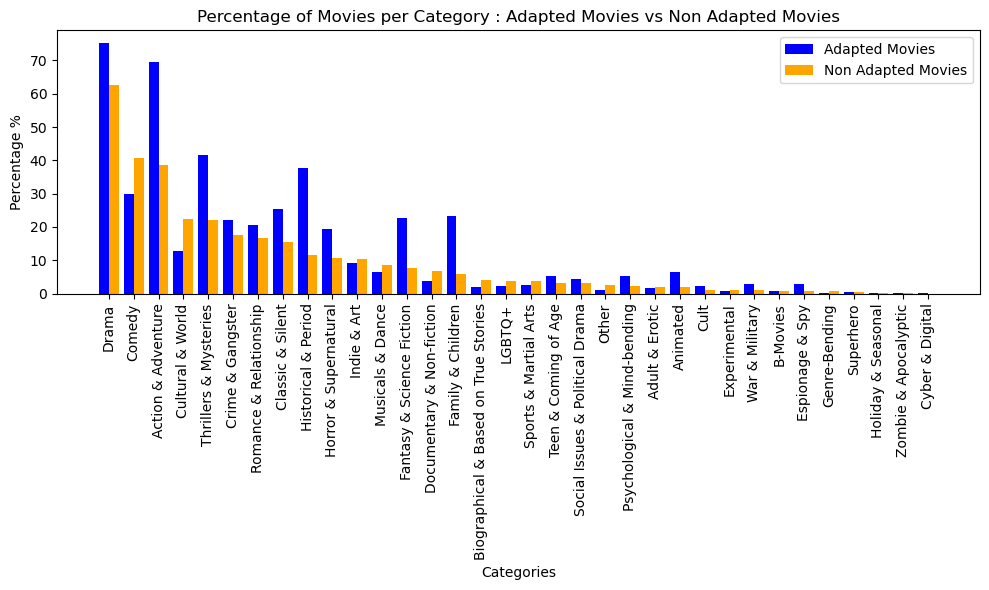

In [25]:
# Comparison Adaptation vs Movies Main Categories
index = range(len(all_vs_adaptation_categories))
bar_width = 0.4  # Width of the bars
plt.figure(figsize=(10, 6))
# Plot the adaptation dataset
plt.bar(index, all_vs_adaptation_categories['Adaptation'], width=bar_width, label='Adapted Movies', color='blue')
# Plot the movie dataset
plt.bar([i + bar_width for i in index], all_vs_adaptation_categories['Movie'], width=bar_width, label='Non Adapted Movies', color='orange')

plt.xlabel('Categories')
plt.ylabel('Percentage %')
plt.title('Percentage of Movies per Category : Adapted Movies vs Non Adapted Movies')
plt.xticks([i + bar_width / 2 for i in index], all_vs_adaptation_categories.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


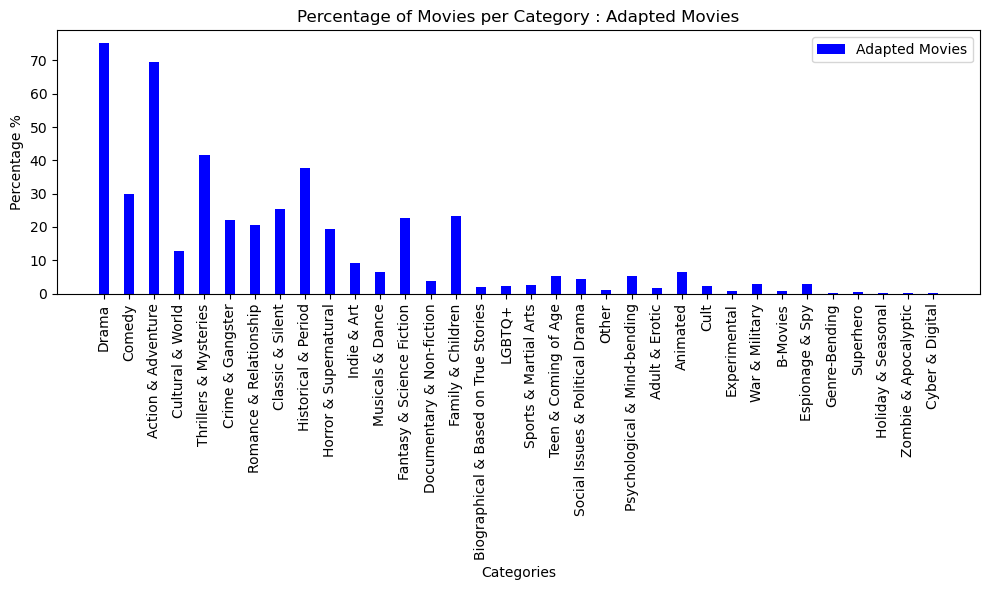

In [31]:
plt.figure(figsize=(10, 6))
plt.bar(index, all_vs_adaptation_categories['Adaptation'], width=bar_width, label='Adapted Movies', color='blue')
plt.xlabel('Categories')
plt.ylabel('Percentage %')
plt.title('Percentage of Movies per Category : Adapted Movies')
plt.xticks([i for i in index], all_vs_adaptation_categories.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

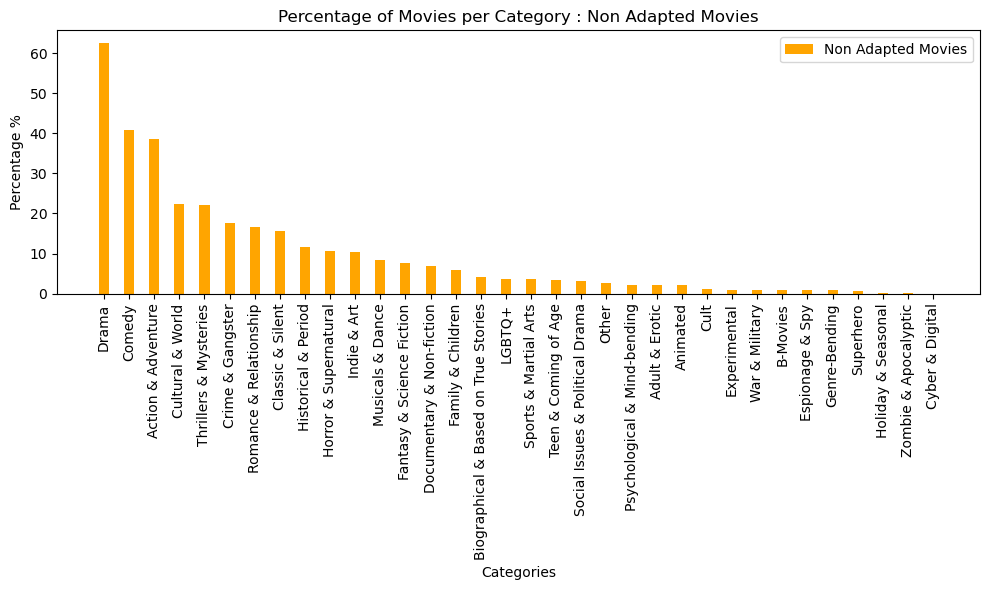

In [34]:
plt.figure(figsize=(10, 6)) 
plt.bar(index, all_vs_adaptation_categories['Movie'].sort_values(ascending=False), width=bar_width, label='Non Adapted Movies', color='orange')
plt.xlabel('Categories')
plt.ylabel('Percentage %')
plt.title('Percentage of Movies per Category : Non Adapted Movies')
plt.xticks([i for i in index], all_vs_adaptation_categories.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

### Average movie date for each category 
Which categories of book adaptations are gaining popularity over time?

In [ ]:
genre_categories = load_genre_categories('data/genre_categories.json')

In [ ]:
df_genres_exploded = explode_MovieGenre(df.copy())

In [ ]:
# Calculate the average movie date for each genre category
average_movie_year = df_genres_exploded.groupby('MovieGenre')['MovieYear'].mean()

# Map genres to categories
average_movie_year_category = average_movie_year.reset_index()
average_movie_year_category['MovieCategory'] = average_movie_year_category['MovieGenre'].map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Calculate the average movie year for each category
average_movie_year_category = average_movie_year_category.groupby('MovieCategory')['MovieYear'].mean()

# Sort the average movie date by descending order
average_movie_year_category = average_movie_year_category.sort_values(ascending=True)

# Plot the average movie date for each genre category
plt.figure(figsize=(8, 4))
average_movie_year_category.plot(kind='bar')
plt.title('Average Movie Year per Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Average Movie Year')
plt.xticks(rotation=90)
plt.ylim(average_movie_year_category.min() - 10, average_movie_year_category.max() + 10)
plt.show()

### Average box office for each genre category
Which genre category has attracted the most attention based on box office performance?

In [ ]:
# Calculate the average box office for each genre category
average_box_office = df_genres_exploded.dropna(subset=['MovieBoxOffice']).groupby('MovieGenre')['MovieBoxOffice'].mean()

# Map genres to categories
average_box_office_category = average_box_office.reset_index()
average_box_office_category['MovieCategory'] = average_box_office_category['MovieGenre'].map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Calculate the average box office for each category
average_box_office_category = average_box_office_category.groupby('MovieCategory')['MovieBoxOffice'].mean()

# Sort the average box office by descending order
average_box_office_category = average_box_office_category.sort_values(ascending=False)

# Plot the average box office for each genre category
plt.figure(figsize=(8, 4))
average_box_office_category.plot(kind='bar')
plt.title('Average Box Office per Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Average Box Office ($100 million)')
plt.xticks(rotation=90)
plt.ylim(0, average_box_office_category.max() + average_box_office_category.max()/10)
plt.show()

The analysis above was very simple. To conduct a more detailed analysis, we take into account the inflation to give a more accurate picture of box office trends. We take 1908 as the reference year.


Source : https://www.officialdata.org/us/inflation/1908?endYear=2013&amount=1

In [ ]:
from matplotlib.ticker import AutoMinorLocator

min_date = df['MovieYear'].min()
max_date = df['MovieYear'].max()

print(f"Min movie_date: {min_date}")
print(f"Max movie_date: {max_date}")

# Load the dollar inflation data
inflation_data = pd.read_csv('data/dollar_inflation.csv')

# Plot the inflation data
plt.figure(figsize=(10, 6))
plt.plot(inflation_data['year'], inflation_data['inflation'])
plt.title('Dollar Inflation Over Time')
plt.xlabel('Year')
plt.ylabel('Dollar [$]')
plt.grid(which='both', axis='y', linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.xticks(list(range(1910, 2024, 10)) + [1908, 2024])  # Set x-ticks every 10 years, plus 1908 and 2024
plt.show()

In [ ]:
# Merge df_genres_exploded with inflation_data on the column movie_date and year
df_merged_genres_inflation = pd.merge(df_genres_exploded, inflation_data, left_on='MovieYear', right_on='year')

# Calculate the adjusted box office for each movie
df_merged_genres_inflation['MovieAdjustedBoxOffice'] = df_merged_genres_inflation['MovieBoxOffice'] / df_merged_genres_inflation['inflation']

# Calculate the average adjusted box office for each genre category
average_adjusted_box_office = df_merged_genres_inflation.dropna(subset=['MovieAdjustedBoxOffice']).groupby('MovieGenre')['MovieAdjustedBoxOffice'].mean()

# Map genres to categories
average_adjusted_box_office_category = average_adjusted_box_office.reset_index()
average_adjusted_box_office_category['MovieCategory'] = average_adjusted_box_office_category['MovieGenre'].map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Calculate the average adjusted box office for each category
average_adjusted_box_office_category = average_adjusted_box_office_category.groupby('MovieCategory')['MovieAdjustedBoxOffice'].mean()

# Sort the average adjusted box office by descending order
average_adjusted_box_office_category = average_adjusted_box_office_category.sort_values(ascending=False)

# Plot the average adjusted box office for each genre category
plt.figure(figsize=(8, 4))
average_adjusted_box_office_category.plot(kind='bar')
plt.title('Average Adjusted Box Office per Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Average Adjusted Box Office ($100 million)')
plt.xticks(rotation=90)
plt.ylim(0, average_adjusted_box_office_category.max() + average_adjusted_box_office_category.max()/10)
plt.show()

### Average runtime for each category 
Although this would need further investigation, analyzing the runtime of book-to-movie adaptations by category can provide insight into how different genres balance storytelling depth and audience expectations. It can highlight the compromises between narrative compression and fidelity to the source material.

In [ ]:
# Calculate the average runtime for each genre category
average_runtime = df_genres_exploded.dropna(subset=['MovieRuntime']).groupby('MovieGenre')['MovieRuntime'].mean()

# Map genres to categories
average_runtime_category = average_runtime.reset_index()
average_runtime_category['MovieCategory'] = average_runtime_category['MovieGenre'].map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Calculate the average runtime for each category
average_runtime_category = average_runtime_category.groupby('MovieCategory')['MovieRuntime'].mean()

# Sort the average runtime by descending order
average_runtime_category = average_runtime_category.sort_values(ascending=False)

# Plot the average runtime for each genre category
plt.figure(figsize=(8, 4))
average_runtime_category.plot(kind='bar')
plt.title('Average Runtime per Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Average Runtime (minutes)')
plt.xticks(rotation=90)
plt.ylim(average_runtime_category.min() - 10, average_runtime_category.max() + 10)
plt.show()

## Book-to-movie analysis by language and category
This analysis examines the distribution of movies across different genre categories and languages. This can provide insights into how genre preferences vary across linguistic contexts, potentially reflecting cultural influences. 

In [ ]:
# Separate the languages by each comma and explode the list into separate rows
df_genres_exploded['MovieLanguage'] = df_genres_exploded['MovieLanguage'].str.split(', ')
df_genres_exploded_languages_exploded = df_genres_exploded.explode('MovieLanguage')

# Clean the languages by removing the word "Language"
df_genres_exploded_languages_exploded['MovieLanguage'] = df_genres_exploded_languages_exploded['MovieLanguage'].str.replace(' Language', '')

In [ ]:
# Group by genre categories and languages, and count the number of movies in each combination
language_counts = df_genres_exploded_languages_exploded.groupby(['MovieGenre', 'MovieLanguage']).size().unstack()

# Get the top 10 most used languages
top_languages = language_counts.sum().sort_values(ascending=False).head(10).index

# Map genres to categories
language_counts['MovieCategory'] = language_counts.index.map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Group by genre categories and languages, and count the number of movies in each combination
language_counts = language_counts.groupby('MovieCategory').sum()

# Keep only the top 10 languages and group the rest into 'Other'
language_counts['Other'] = language_counts.drop(columns=top_languages).sum(axis=1)
language_counts = language_counts[top_languages.tolist() + ['Other']]

# Sort the genre categories by the total number of movies in descending order
language_counts = language_counts.loc[language_counts.sum(axis=1).sort_values(ascending=False).index]

# Plot the stacked bar chart
unique_languages = language_counts.columns
colors = sns.color_palette(cc.glasbey_category10, n_colors=len(unique_languages))  # Get a unique color for each language

language_counts[unique_languages].plot(kind='bar', stacked=True, figsize=(8, 4), color=colors)
plt.title('Number of Movies per Language in each Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Calculate the percentage of movies in each language for each genre category
language_counts_percentage = language_counts.div(language_counts.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart by percentage
language_counts_percentage[unique_languages].plot(kind='bar', stacked=True, figsize=(8, 4), color=colors)
plt.title('Percentage of Movies per Language in each Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Percentage of Movies')
plt.xticks(rotation=90)
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Book-to-movie analysis by country and category


In [ ]:
# Separate the countries by each comma and explode the list into separate rows
df_genres_exploded['MovieCountries'] = df_genres_exploded['MovieCountries'].str.split(', ')
df_genres_exploded_countries_exploded = df_genres_exploded.explode('MovieCountries')

In [ ]:
# Group by genre categories and countries, and count the number of movies in each combination
country_counts = df_genres_exploded_countries_exploded.groupby(['MovieGenre', 'MovieCountries']).size().unstack()

# Get the top 10 most used countries
top_countries = country_counts.sum().sort_values(ascending=False).head(10).index

# Map genres to categories
country_counts['MovieCategory'] = country_counts.index.map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Group by genre categories and countries, and count the number of movies in each combination
country_counts = country_counts.groupby('MovieCategory').sum()

# Keep only the top 10 countries and group the rest into 'Other'
country_counts['Other'] = country_counts.drop(columns=top_countries).sum(axis=1)
country_counts = country_counts[top_countries.tolist() + ['Other']]

# Sort the genre categories by the total number of movies in descending order
country_counts = country_counts.loc[country_counts.sum(axis=1).sort_values(ascending=False).index]

# Plot the stacked bar chart
unique_countries = country_counts.columns
colors = sns.color_palette(cc.glasbey_category10, n_colors=len(unique_countries))  # Get a unique color for each country

country_counts[unique_countries].plot(kind='bar', stacked=True, figsize=(8, 4), color=colors)
plt.title('Number of Movies per Country in each Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Calculate the percentage of movies in each country for each genre category
country_counts_percentage = country_counts.div(country_counts.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart by percentage
country_counts_percentage[unique_countries].plot(kind='bar', stacked=True, figsize=(8, 4), color=colors)
plt.title('Percentage of Movies per Country in each Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Percentage of Movies')
plt.xticks(rotation=90)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Authors Cherished by the World of Cinema
This analysis highlights authors whose works have inspired the most movie adaptations. This can offer insights into literary trends that are particularly popular in cinema.

In [ ]:
# Get the top 10 authors by the number of movies
top_authors = adapted_movies['BookAuthor'].value_counts().head(25)

# Plot the bar chart
plt.figure(figsize=(8, 4))
top_authors.plot(kind='bar')
plt.title('Number of Movies per Book Author')
plt.xlabel('Book Author')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90, ha='right')
plt.show()

## Number of adaptations from books made over time
This analysis could reveal periods of increased interest in book-to-movie adaptations, helping identify cultural, societal, or industry-driven factors that influenced these trends, such as shifts in audience preferences.

In [ ]:
# Group the adapted_movies dataframe by MovieYear and count the number of movies released each year
adapted_movies_per_year = adapted_movies.groupby('MovieYear').size().reset_index(name='movie_count')

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(adapted_movies_per_year['MovieYear'], adapted_movies_per_year['movie_count'])
plt.title('Number of Adapted Movies Released Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

## Impact of Book Release Dates on Movie Adaptations
How does the timing of a book’s release influence its cinematic potential ?\
This analysis explores the correlation between the release dates of books and the number of movie adaptations they inspire. 

In [ ]:
# Load the adapted_movies dataset
adapted_movies = pd.read_csv('src/adapted_movies.csv')

# Drop rows with NaN values in 'BookStartYear'
adapted_movies = adapted_movies.dropna(subset=['BookStartYear'])

# Convert 'BookStartYear' to integer
adapted_movies['BookStartYear'] = adapted_movies['BookStartYear'].astype(int)

# Create a new column for the decade
adapted_movies['BookDecade'] = (adapted_movies['BookStartYear'] // 10) * 10

# Plot the bar chart grouped by decade
plt.figure(figsize=(10, 4))
adapted_movies['BookDecade'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Movies per Book Release Date')
plt.xlabel('Book Release Date (Decade)')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()